In [19]:
import pandas as pd
import itertools
import numpy as np
from datetime import datetime
import rasterio
from pyproj import Transformer
from shapely.geometry import Point, LineString
import geopandas as gpd
import contextily as cx
from typing import Dict, List, Tuple
import ciso8601

In [2]:
filename = "North-East_American_Canada_goose_migration.csv"
df = pd.read_csv(filename)

In [3]:
df = df.drop(['event-id', 'visible', 'sensor-type', 'tag-local-identifier', 'individual-taxon-canonical-name', 'study-name'], axis='columns')
df

,timestamp,location-long,location-lat,height-raw,individual-local-identifier
0,2018-09-13 05:03:05.000,-78.879761,51.931995,0.0,1208-75545
1,2018-09-13 05:18:21.000,-78.879494,51.931984,-4.0,1208-75545
2,2018-09-13 05:33:34.000,-78.878960,51.931919,-2.0,1208-75545
3,2018-09-13 05:48:47.000,-78.877037,51.932232,-6.0,1208-75545
4,2018-09-13 06:19:29.000,-78.875763,51.932835,31.0,1208-75545
...,...,...,...,...,...
1681148,2021-02-01 12:08:02.000,-75.620537,39.791382,40.0,1208-79489
1681149,2021-02-01 12:22:57.000,-75.617867,39.790588,811.0,1208-79489
1681150,2021-02-01 12:38:20.000,-75.619286,39.790016,88.0,1208-79489
1681151,2021-02-01 12:52:57.000,-75.619354,39.791069,63.0,1208-79489


In [7]:
df['location-long'] = df['location-long'].apply(lambda x: np.round(x * 2, 4) / 2)
df['location-lat'] = df['location-lat'].apply(lambda x: np.round(x * 2, 4) / 2)
df

,timestamp,location-long,location-lat,height-raw,individual-local-identifier
0,2018-09-13 05:03:05.000,-78.87975,51.93200,0.0,1208-75545
1,2018-09-13 05:18:21.000,-78.87950,51.93200,-4.0,1208-75545
2,2018-09-13 05:33:34.000,-78.87895,51.93190,-2.0,1208-75545
3,2018-09-13 05:48:47.000,-78.87705,51.93225,-6.0,1208-75545
4,2018-09-13 06:19:29.000,-78.87575,51.93285,31.0,1208-75545
...,...,...,...,...,...
1681148,2021-02-01 12:08:02.000,-75.62055,39.79140,40.0,1208-79489
1681149,2021-02-01 12:22:57.000,-75.61785,39.79060,811.0,1208-79489
1681150,2021-02-01 12:38:20.000,-75.61930,39.79000,88.0,1208-79489
1681151,2021-02-01 12:52:57.000,-75.61935,39.79105,63.0,1208-79489


In [8]:
animals = df['individual-local-identifier'].unique()
animal_pairs = list(itertools.combinations(animals, 2))
animal_pairs

bird_intersections = pd.DataFrame()
for animal1, animal2 in animal_pairs:
    bird1 = df[df['individual-local-identifier'] == animal1]
    bird2 = df[df['individual-local-identifier'] == animal2]
    intersctions = bird1.merge(bird2, on=['location-long', 'location-lat'])
    bird_intersections = pd.concat([bird_intersections, intersctions])

In [9]:
bird_intersections

,timestamp_x,location-long,location-lat,height-raw_x,individual-local-identifier_x,timestamp_y,height-raw_y,individual-local-identifier_y
0,2018-09-14 00:04:45.000,-78.87840,51.92800,-1.0,1208-75545,2018-09-30 19:02:04.000,-10.0,1208-75628
1,2018-09-14 18:26:35.000,-78.86450,51.93865,-4.0,1208-75545,2018-10-01 05:20:02.000,-2.0,1208-75628
2,2018-09-15 02:11:00.000,-78.87510,51.94105,6.0,1208-75545,2018-09-23 10:29:00.000,-2.0,1208-75628
3,2018-09-15 02:11:00.000,-78.87510,51.94105,6.0,1208-75545,2018-09-23 10:44:13.000,-5.0,1208-75628
4,2018-09-15 02:26:12.000,-78.87515,51.94105,-3.0,1208-75545,2018-09-23 10:13:47.000,0.0,1208-75628
...,...,...,...,...,...,...,...,...
501,2020-09-14 09:31:42.000,-69.94965,60.12965,80.0,1208-79485,2020-09-14 04:32:52.000,74.0,1208-79489
502,2020-09-14 09:31:42.000,-69.94965,60.12965,80.0,1208-79485,2020-09-14 04:47:59.000,79.0,1208-79489
503,2020-09-14 09:01:20.000,-69.94965,60.12960,76.0,1208-79485,2020-09-14 06:33:49.000,79.0,1208-79489
504,2020-09-14 09:01:20.000,-69.94965,60.12960,76.0,1208-79485,2020-09-14 08:18:21.000,73.0,1208-79489


In [10]:
bird_intersections['timestamp_x'] = bird_intersections['timestamp_x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
bird_intersections['timestamp_y'] = bird_intersections['timestamp_y'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
bird_intersections['time_diff'] = bird_intersections['timestamp_x'] - bird_intersections['timestamp_y']
bird_intersections['time_diff'] = bird_intersections['time_diff'].apply(lambda x: abs(x.total_seconds()))
bird_intersections = bird_intersections.drop(['timestamp_x', 'timestamp_y'], axis='columns')
bird_intersections

,location-long,location-lat,height-raw_x,individual-local-identifier_x,height-raw_y,individual-local-identifier_y,time_diff
0,-78.87840,51.92800,-1.0,1208-75545,-10.0,1208-75628,1450639.0
1,-78.86450,51.93865,-4.0,1208-75545,-2.0,1208-75628,1421607.0
2,-78.87510,51.94105,6.0,1208-75545,-2.0,1208-75628,721080.0
3,-78.87510,51.94105,6.0,1208-75545,-5.0,1208-75628,721993.0
4,-78.87515,51.94105,-3.0,1208-75545,0.0,1208-75628,719255.0
...,...,...,...,...,...,...,...
501,-69.94965,60.12965,80.0,1208-79485,74.0,1208-79489,17930.0
502,-69.94965,60.12965,80.0,1208-79485,79.0,1208-79489,17023.0
503,-69.94965,60.12960,76.0,1208-79485,79.0,1208-79489,8851.0
504,-69.94965,60.12960,76.0,1208-79485,73.0,1208-79489,2579.0


In [11]:
bird_interactions = bird_intersections[bird_intersections['time_diff'] <= 1200]
bird_interactions

,location-long,location-lat,height-raw_x,individual-local-identifier_x,height-raw_y,individual-local-identifier_y,time_diff
41,-78.87800,51.92905,-7.0,1208-75545,-9.0,1208-75628,895.0
43,-78.87815,51.92895,-10.0,1208-75545,-4.0,1208-75628,87.0
84,-78.87800,51.92895,-6.0,1208-75545,-5.0,1208-75628,938.0
94,-78.87720,51.92945,-11.0,1208-75545,-7.0,1208-75628,69.0
95,-78.87530,51.92820,0.0,1208-75545,-7.0,1208-75628,6.0
...,...,...,...,...,...,...,...
190,-74.65125,42.88300,253.0,1208-80930,252.0,1208-79449,302.0
8,-74.17690,44.85295,358.0,1278-00643,347.0,1208-79485,303.0
51,-70.00570,60.16165,40.0,1208-79468,78.0,1208-79485,488.0
52,-70.01770,60.16190,87.0,1208-79468,89.0,1208-79485,741.0


In [12]:
dat = rasterio.open('land_cover_2020_30m_tif/NA_NALCMS_landcover_2020_30m/data/NA_NALCMS_landcover_2020_30m.tif')
transformer = Transformer.from_crs("epsg:4326", dat.crs)

In [13]:
def get_val_from_tif(dat, x, y):
    values = list(rasterio.sample.sample_gen(dat, [(x, y)]))
    return values[0][0]

In [14]:
terrain = []
for _, row in bird_interactions.iterrows():
    x, y = transformer.transform(row['location-lat'], row['location-long'])
    terrain.append(get_val_from_tif(dat, x, y))

In [15]:
bird_interactions['terrain'] = terrain
bird_interactions

/tmp/ipykernel_3243/4145755766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_interactions['terrain'] = terrain


,location-long,location-lat,height-raw_x,individual-local-identifier_x,height-raw_y,individual-local-identifier_y,time_diff,terrain
41,-78.87800,51.92905,-7.0,1208-75545,-9.0,1208-75628,895.0,8
43,-78.87815,51.92895,-10.0,1208-75545,-4.0,1208-75628,87.0,0
84,-78.87800,51.92895,-6.0,1208-75545,-5.0,1208-75628,938.0,0
94,-78.87720,51.92945,-11.0,1208-75545,-7.0,1208-75628,69.0,0
95,-78.87530,51.92820,0.0,1208-75545,-7.0,1208-75628,6.0,14
...,...,...,...,...,...,...,...,...
190,-74.65125,42.88300,253.0,1208-80930,252.0,1208-79449,302.0,15
8,-74.17690,44.85295,358.0,1278-00643,347.0,1208-79485,303.0,15
51,-70.00570,60.16165,40.0,1208-79468,78.0,1208-79485,488.0,12
52,-70.01770,60.16190,87.0,1208-79468,89.0,1208-79485,741.0,13


In [16]:
bird_interactions.to_csv("bird_interactions", index=False)

# Inne

In [29]:
filename = "North-East_American_Canada_goose_migration.csv"
df = pd.read_csv(filename)

In [30]:
df['geometry'] = df[['location-long', 'location-lat']].apply(lambda long_and_lat: Point(long_and_lat.iloc[0], long_and_lat.iloc[1]), axis=1)

In [31]:
df = df.drop(['location-long', 'location-lat', 'event-id', 'visible', 'sensor-type', 'tag-local-identifier', 'individual-taxon-canonical-name', 'study-name'], axis='columns')
df = gpd.GeoDataFrame(df, geometry='geometry')
df.crs = "Epsg:4326"
df = df.to_crs(epsg=4326)
gdf = df
gdf

,event-id,visible,timestamp,location-long,location-lat,height-raw,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
0,22514259375,True,2018-09-13 05:03:05.000,-78.879761,51.931995,0.0,gps,Branta canadensis,s89460800120046876114,1208-75545,North-East American Canada goose migration,POINT (-78.87976 51.93200)
1,22514259383,True,2018-09-13 05:18:21.000,-78.879494,51.931984,-4.0,gps,Branta canadensis,s89460800120046876114,1208-75545,North-East American Canada goose migration,POINT (-78.87949 51.93198)
2,22514259391,True,2018-09-13 05:33:34.000,-78.878960,51.931919,-2.0,gps,Branta canadensis,s89460800120046876114,1208-75545,North-East American Canada goose migration,POINT (-78.87896 51.93192)
3,22514259400,True,2018-09-13 05:48:47.000,-78.877037,51.932232,-6.0,gps,Branta canadensis,s89460800120046876114,1208-75545,North-East American Canada goose migration,POINT (-78.87704 51.93223)
4,22514259416,True,2018-09-13 06:19:29.000,-78.875763,51.932835,31.0,gps,Branta canadensis,s89460800120046876114,1208-75545,North-East American Canada goose migration,POINT (-78.87576 51.93283)
...,...,...,...,...,...,...,...,...,...,...,...,...
1681148,22515525341,True,2021-02-01 12:08:02.000,-75.620537,39.791382,40.0,gps,Branta canadensis,s182870,1208-79489,North-East American Canada goose migration,POINT (-75.62054 39.79138)
1681149,22515525351,True,2021-02-01 12:22:57.000,-75.617867,39.790588,811.0,gps,Branta canadensis,s182870,1208-79489,North-East American Canada goose migration,POINT (-75.61787 39.79059)
1681150,22515525357,True,2021-02-01 12:38:20.000,-75.619286,39.790016,88.0,gps,Branta canadensis,s182870,1208-79489,North-East American Canada goose migration,POINT (-75.61929 39.79002)
1681151,22515525364,True,2021-02-01 12:52:57.000,-75.619354,39.791069,63.0,gps,Branta canadensis,s182870,1208-79489,North-East American Canada goose migration,POINT (-75.61935 39.79107)


In [32]:
linestrings: Dict[str, LineString] = {}
animals = gdf['individual-local-identifier'].unique()
for animal in animals:
    animal_gdf = gdf[gdf['individual-local-identifier'] == animal]
    animal_gdf = animal_gdf.sort_values('timestamp')
    linestrings[animal] = LineString(animal_gdf['geometry'].to_list())

In [33]:
data = {}
data['animal_tag'] = []
data['geometry'] = []
for key, value in linestrings.items():
    data['animal_tag'].append(key)
    data['geometry'].append(value)

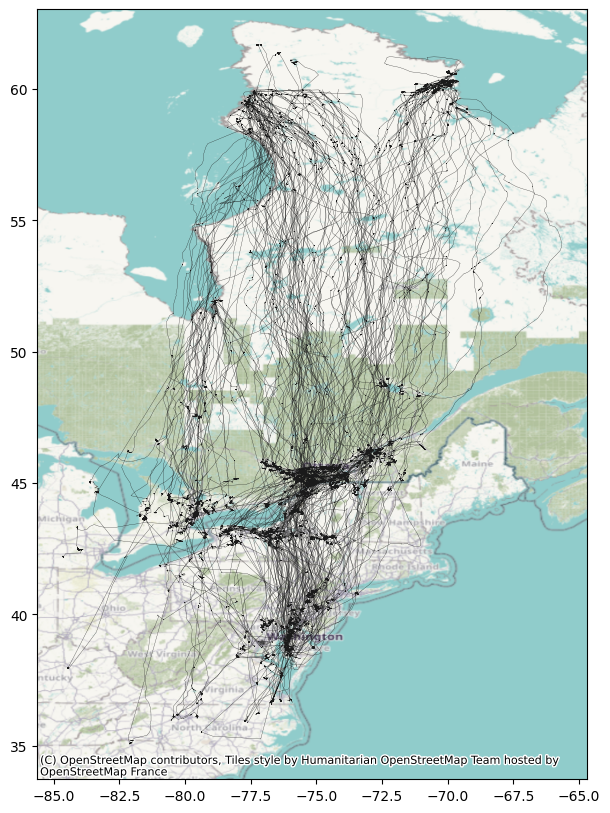

In [34]:
gdf = gpd.GeoDataFrame(data)
gdf.crs = "Epsg:4326"
gdf = gdf.to_crs(epsg=4326)
gdf
ax = gdf.plot(cmap='OrRd', figsize=(10,10), linewidth=0.2, edgecolor='0.1', vmin=0, vmax=1)

# ax = gdf.plot(figsize=(9,9), color="none", edgecolor='0.2', linewidth=3)
cx.add_basemap(ax, crs=gdf.crs.to_string())

In [35]:
animal_infos: Dict[str, gpd.GeoDataFrame] = {}
animals = df['individual-local-identifier'].unique()
for animal in animals:
    animal_df = df[df['individual-local-identifier'] == animal]
    animal_infos[animal] = animal_df
    

animal_positions_with_timestamps: Dict[str, Tuple[np.array, np.array]] = {}
for animal, animal_df in animal_infos.items():
    animal_df['timestamp'] = animal_df['timestamp'].apply(lambda t: ciso8601.parse_datetime(t).timestamp())
    
    animal_df = animal_df.sort_values('timestamp')
    geometry = animal_df['geometry'].to_numpy()
    timestamp = animal_df['timestamp'].to_numpy()
    animal_positions_with_timestamps[animal] = (geometry, timestamp)

/home/chebawca/canadian_goose_interactions/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/chebawca/canadian_goose_interactions/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/chebawca/canadian_goose_interactions/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A va

In [36]:
def get_animal_position(pos_and_time, timestamp):
    pos, _time = pos_and_time
    index = np.searchsorted(_time, timestamp)
    if index == len(_time):
        return pos[-1]
    elif index == 0:
        return pos[0]
    elif timestamp == _time[index]:
        return pos[index]
    else:
        t1 = _time[index-1]
        t2 = _time[index]
        p1 = pos[index-1]
        p2 = pos[index]
        interpolation_factor = (timestamp - t1) / (t2 - t1)
        return p1.interpolate(interpolation_factor, p2)
        

def create_dataframe_for_timestamp(timestamp: float):
    tags = []
    positions = []
    for animal, pos_and_time in animal_positions_with_timestamps.items():
        position = get_animal_position(pos_and_time, timestamp)
        positions.append(position)
        tags.append(animal)
    data = {}
    data['animal_tag'] = tags
    data['geometry'] = positions
    return gpd.GeoDataFrame(data)

In [37]:
gdf_for_timestamp = create_dataframe_for_timestamp(ciso8601.parse_datetime("2018-09-30 23:19:09.000").timestamp())
gdf_for_timestamp.crs = "Epsg:4326"
gdf_for_timestamp = gdf_for_timestamp.to_crs(epsg=4326)
bx = gdf_for_timestamp.plot(cmap='OrRd', marker='.', markersize=80, figsize=(10,10), linewidth=0.2, edgecolor='0.1', vmin=0, vmax=1)
cx.add_basemap(bx, crs=gdf_for_timestamp.crs.to_string())

TypeError: One of the Geometry inputs is of incorrect geometry type.